In [1]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from dictionary import AutoEncoder



/Users/ryansherby/opt/anaconda3/envs/pyML/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load sentences from CSV file
df = pd.read_csv("sentences.csv", delimiter=",", encoding="utf-8", quotechar='"')
sentences = df['sentence'].tolist()

print(sentences)

['Black is technically the absence of visible light, which makes it pretty fascinating when you think about it.', 'You know, black is one of those colors that just never goes out of style.', 'It’s interesting how black is often associated with sophistication and elegance—think of a classic black tuxedo.', 'In many cultures, black symbolizes mystery, power, and sometimes mourning.', 'Black holes are some of the most mysterious objects in the universe—they’re literally regions where light can’t escape.', 'When it comes to fashion, black is the go-to color for a timeless, sleek look.', 'Isn’t it cool how black objects absorb more heat because they absorb all wavelengths of light?', 'Matte black has such a modern, bold aesthetic—it’s so popular in car designs these days.', 'Black is often used in branding when companies want to convey authority and reliability.', 'Ever notice how black makes other colors stand out more when used as a background?', 'In photography, black-and-white images ha

In [4]:
# Load the Pythia model and tokenizer
model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-70m-deduped")
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m-deduped")
tokenizer.pad_token = tokenizer.eos_token

The `GPTNeoXSdpaAttention` class is deprecated in favor of simply modifying the `config._attn_implementation`attribute of the `GPTNeoXAttention` class! It will be removed in v4.48


In [5]:
# Testing tokenizer 
sentence = "You know, black is one of those colors that just never goes out of style."
tokenized_sentence = tokenizer(sentence)['input_ids']
decoded_tokens = tokenizer.convert_ids_to_tokens(tokenized_sentence)

print("Tokenized output:", decoded_tokens)

Tokenized output: ['You', 'Ġknow', ',', 'Ġblack', 'Ġis', 'Ġone', 'Ġof', 'Ġthose', 'Ġcolors', 'Ġthat', 'Ġjust', 'Ġnever', 'Ġgoes', 'Ġout', 'Ġof', 'Ġstyle', '.']


In [6]:
activation_list = []

def hook_fn(module, input, output):
    """Hook function to capture activations from the 4th MLP layer."""
    activation_list.append(output)

# Hook 4th MLP layer (index 3)
layer_to_hook = model.gpt_neox.layers[3].mlp
hook = layer_to_hook.register_forward_hook(hook_fn)


In [7]:
# Store per-token activations
individual_activations = []

# Target values
target_values = ['black','Black','ĠBlack','Ġblack']
    
for sentence in sentences:
    print(f"\nProcessing: '{sentence}'")
    input_ids_batch = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
    model(**input_ids_batch)  # Forward pass to capture activations

    decoded_tokens = tokenizer.convert_ids_to_tokens(input_ids_batch['input_ids'][0])

    target_idx = [i for i, word in enumerate(decoded_tokens) if word in target_values]

    if not target_idx:
        print(f"Target word not found in sentence: {decoded_tokens}")
        continue
    else:
        target_idx = target_idx[0]

    if activation_list:
        activations = activation_list[-1].squeeze(0)  # Shape: (seq_len, hidden_dim)
        individual_activations.append((activations,target_idx))
    activation_list.clear()

print(f"Captured activations for {len(individual_activations)} sentences.")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Processing: 'Black is technically the absence of visible light, which makes it pretty fascinating when you think about it.'

Processing: 'You know, black is one of those colors that just never goes out of style.'

Processing: 'It’s interesting how black is often associated with sophistication and elegance—think of a classic black tuxedo.'

Processing: 'In many cultures, black symbolizes mystery, power, and sometimes mourning.'

Processing: 'Black holes are some of the most mysterious objects in the universe—they’re literally regions where light can’t escape.'

Processing: 'When it comes to fashion, black is the go-to color for a timeless, sleek look.'

Processing: 'Isn’t it cool how black objects absorb more heat because they absorb all wavelengths of light?'

Processing: 'Matte black has such a modern, bold aesthetic—it’s so popular in car designs these days.'

Processing: 'Black is often used in branding when companies want to convey authority and reliability.'

Processing: 'Ever no

In [8]:
# Load Dictionary Learning AutoEncoder
ae = AutoEncoder.from_pretrained(
    "dictionaries/pythia-70m-deduped/mlp_out_layer3/10_32768/ae.pt", 
    map_location=torch.device('cpu')
)

/Users/ryansherby/Library/CloudStorage/OneDrive-Personal/Documents/Columbia/CRIS Lab Project/dictionary_learning/dictionary.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featur

In [9]:
# Convert activations to sparse representations
sparse_representations = []
for activations, tgt_idx in individual_activations:
    sparse_repr = ae.encode(activations).detach().cpu().numpy()  # (seq_len, dict_size)
    sparse_representations.append((sparse_repr, tgt_idx))
print(f"Processed {len(sparse_representations)} sentences into token-aligned sparse representations.")

Processed 59 sentences into token-aligned sparse representations.


In [25]:
individual_activations[0][0].shape

torch.Size([20, 512])

In [11]:
# Aggregate features: Average values for target word over all sentences
aggregate_vector = np.zeros((ae.dict_size,))
for sentence_features,target_idx in sparse_representations:
    aggregate_vector += sentence_features[target_idx]

aggregate_vector /= len(sparse_representations)  # Normalize by number of sentences


# Normalize and scale

agg_vec_norm = np.linalg.norm(aggregate_vector, ord=2)

aggregate_vector /= agg_vec_norm

aggregate_vector * 1000
            

array([0., 0., 0., ..., 0., 0., 0.])

In [12]:

def cosine_similarity_matrix(vectors):
    """
    Computes the cosine similarity matrix for a set of vectors.
    
    Parameters:
    vectors (np.ndarray): A 2D array where each row is a vector.
    
    Returns:
    np.ndarray: A 2D cosine similarity matrix.
    """
    # Compute the L2 norms for each vector (row)
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    
    # Avoid division by zero by replacing zero norms with a very small number
    norms[norms == 0] = 1e-10
    
    # Normalize each vector to have unit length
    normalized_vectors = vectors / norms
    
    # Compute the cosine similarity matrix as the dot product of the normalized vectors
    similarity_matrix = np.dot(normalized_vectors, normalized_vectors.T)
    
    return similarity_matrix


# Compute cosine similarity matrix
similarity_matrix = cosine_similarity_matrix(np.matrix([sentence_features[target_idx] for sentence_features,target_idx in sparse_representations]))

<Axes: >

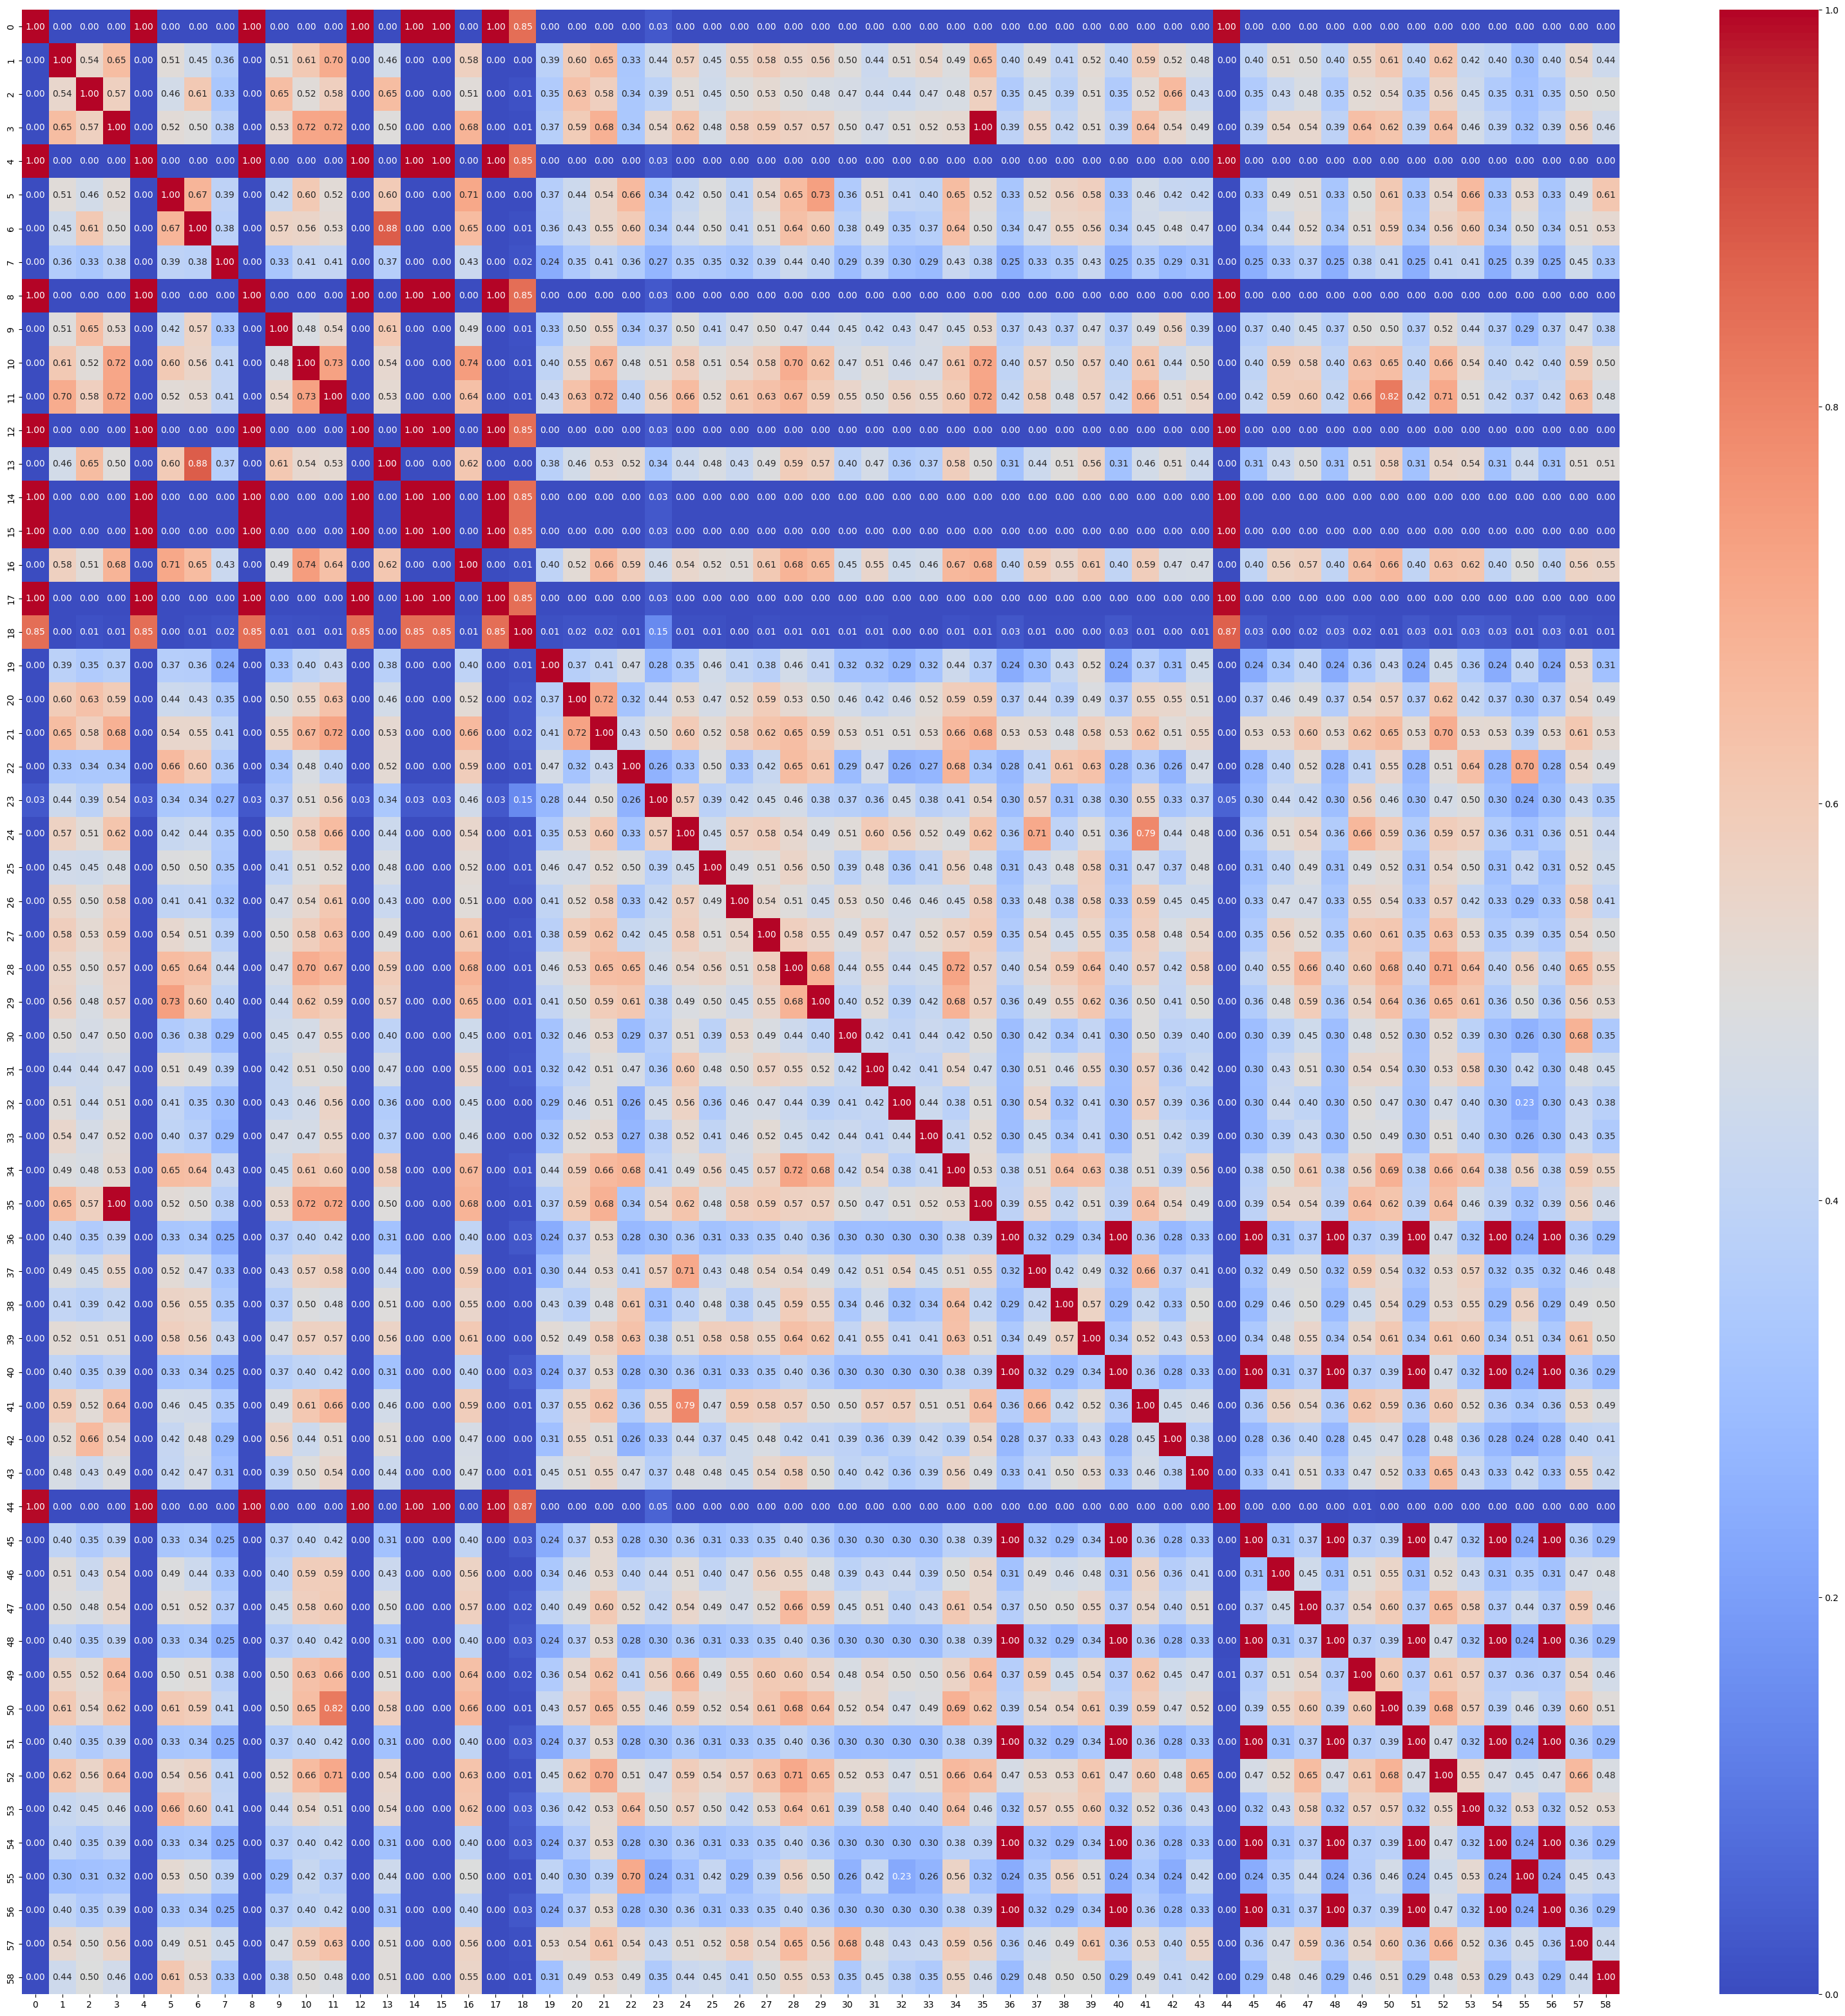

In [13]:
import seaborn as sns

import matplotlib.pyplot as plt

plt.figure(figsize=(40, 40))

sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap='coolwarm')



In [14]:
print(sentences[18])
print(sentences[44])

A black night sky without city lights always makes me feel like I’m staring into infinity.
Many predators use black coloring to help them stay hidden at night.


In [15]:
# # Analyze which features activate for specific tokens
# top_n = 800  
# top_features = []

# for sentence_idx, per_token_features in enumerate(sparse_representations):
#     sentence_top_features = []
    
#     for token_idx, features in enumerate(per_token_features):
#         # Extract top N active features for this token
#         top_indices = np.argsort(features)[-top_n:][::-1]
#         sentence_top_features.append(set(top_indices))
    
#     top_features.append(sentence_top_features)  # Store per-token top feature indices

# # Example: Print feature activations for each token in the first sentence
# tokenized_sentence = tokenizer(sentences[0])['input_ids']
# decoded_tokens = tokenizer.convert_ids_to_tokens(tokenized_sentence)

# print("\nFeature activations for the first sentence:")
# for token, feature_set in zip(decoded_tokens, top_features[0]):
#     print(f"Token: {token}, Top Features: {list(feature_set)[:10]}")  # Show top 5 features

#     # Example: Print feature activations for each token in the first sentence
# tokenized_sentence = tokenizer(sentences[1])['input_ids']
# decoded_tokens = tokenizer.convert_ids_to_tokens(tokenized_sentence)

# print("\nFeature activations for the first sentence:")
# for token, feature_set in zip(decoded_tokens, top_features[0]):
#     print(f"Token: {token}, Top Features: {list(feature_set)[:10]}")  # Show top 5 features
    


In [16]:
# Decode sparse vector back into model space
synthetic_dense_vector = ae.decode(torch.tensor(aggregate_vector).float()).detach().cpu()
# synthetic_dense_vector *= 10  # Experiment with scaling


In [17]:
# Add a new special token

masked_sentence = "Do you prefer the color red or blue? I prefer the color"
input_ids = tokenizer(masked_sentence, return_tensors="pt")["input_ids"]

# Convert token IDs to tokens
decoded_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print(f"Tokenized input: {decoded_tokens}")  # Debugging


Tokenized input: ['Do', 'Ġyou', 'Ġprefer', 'Ġthe', 'Ġcolor', 'Ġred', 'Ġor', 'Ġblue', '?', 'ĠI', 'Ġprefer', 'Ġthe', 'Ġcolor']


In [18]:

# Convert input_ids to embeddings
model_inputs = model.get_input_embeddings()(input_ids)

placeholder_index = 5 # Replacing the word red

# Inject synthetic feature vector at the placeholder position
model_inputs[:, placeholder_index, :] *= synthetic_dense_vector

# Generate text from modified embeddings
with torch.no_grad():
    outputs = model(inputs_embeds=model_inputs)
    logits = outputs.logits[:, -1, :]  # Get last token logits
    logs, tokens = torch.topk(logits, 10,dim=-1)


# Decode the predicted token
predicted_words = tokenizer.batch_decode([token.item() for token in tokens[0]])

print(predicted_words)

[' of', ' that', ' to', ' blend', '-', ' I', ' in', ',', 'ier', ' combination']


In [19]:
model_inputs.shape

torch.Size([1, 13, 512])

In [20]:
# Probably can't use true reconstructed feature activations as they are extracted from a different layer
# and are now being pushed through the input layer

# Could try to use some weighted scaling method to scale an input vector
# by the activations of the target word

In [21]:
# General Suggestions

# Input synthetic vector at same layer where derived

# Examine which layer the activations are highest
# and hook into that layer